# Modulação e Demodulação FSK para Comunicação via Ondas Acústicas

## Motivação

 - Ainda que de baixa capacidade, é uma forma de comunicação alternativa à comunicação sem fio via onda eletromagnética, comumente empregadano cotidiano, como telefonia móvel, redes WiFi, dentre outras.
 - É utilizada em ambientes subaquáticos para monitoramento de diferentes áreas, visto que ondas de rádio frequência sofrem altas atenuações a baixas distâncias
 - A modulação de áudio FSK, já utilizada para comunicação subaquática, é bem simples de implementar, e permite testes em ambientes atmosféricos, visto que não é possível (ainda) realizar testes subaquáticos.


## Objetivos

Implementar um processo de comunicação, envolvendo codificação de mensagens, modulação e demodulação de sinais via software através de ondas sonoras moduladas por chaveamento de frequência. Além disso, discutir aspectos da comunicação, bem como suas viabilidade, eficácia e limitações, a partir de testes em ambientes acústicos em que o ar é o meio comunicante.

## Metodologia

Quatro passos:
 - Codificação
 - Modulação
 - Demodulação
 - Decodificação
Verificação por taxa de erro de bit (_BER_)

In [11]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append("../")
sys.path.append("../src/")

from modulation import *
from demodulation import *

## Codificação

Consiste em transformar uma mensagem em um vetor de bits.
À mensagem são adicionados cabeçalho e cauda que serão sincronizados posteriormente


In [12]:
sync = sincronizeMessage("Hello World!")
print(sync)
bits = stringToBits(sync)
print(len(bits), "bits ao todo")

2wLQTcNgiXyP<{Hello World!}>ggIVZMbi09VM
320 bits ao todo


## Modulação

Modular a mensagem seguindo a equação:

<p align="center">
    <a href="https://www.codecogs.com/eqnedit.php?latex=x(t)&space;=&space;A_0cos(2\pi\&space;(f_0&space;&plus;&space;\Delta_f&space;\cdot&space;m_b(t))\&space;t)&space;%0" target="_blank"><img src="https://latex.codecogs.com/gif.latex?x(t)&space;=&space;A_0cos(2\pi\&space;(f_0&space;&plus;&space;\Delta_f&space;\cdot&space;m_b(t))\&space;t)&space;%0" title="x(t) = A_0cos(2\pi\ (f_0 + \Delta_f \cdot m_b(t))\ t) %0" /></a>
</p>


(0.19, 0.21)

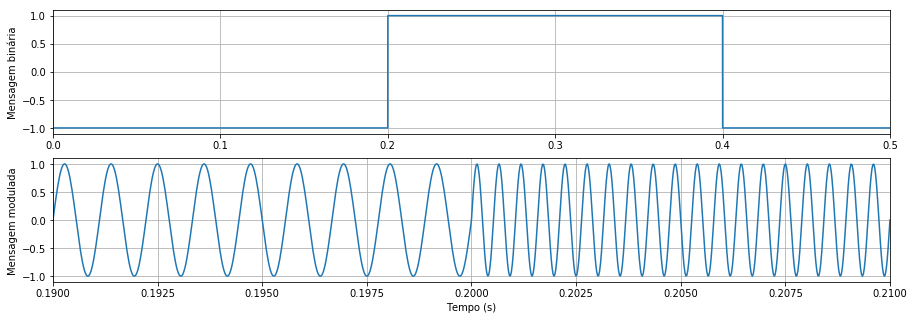

In [13]:
mb = bitsToWave(bits,baud=10)
t, x = FSKMod(mb)

## Plotting Data ##
plt.figure(figsize=(15,5))
ax_bit = plt.subplot(211)
ax_bit.plot(t, mb)
ax_bit.set_ylabel('Mensagem binária')
ax_bit.grid(True)
ax_bit.set_xlim(0.0, 0.5)

ax_mod = plt.subplot(212)
ax_mod.plot(t, x)
ax_mod.set_ylabel('Mensagem modulada')
ax_mod.set_xlabel('Tempo (s)')
ax_mod.grid(True)
ax_mod.set_xlim(0.19, 0.21)


In [14]:
## Escute o áudio ##
ipd.Audio(x, rate=44100)

## Demodulação

Processo não-coerente, isto é, não depende da fase para ser feito. O processo pode ser sintetizado pela figura:

<img src="demod.png" alt="demod" width="800"/>



(420000, 470000)

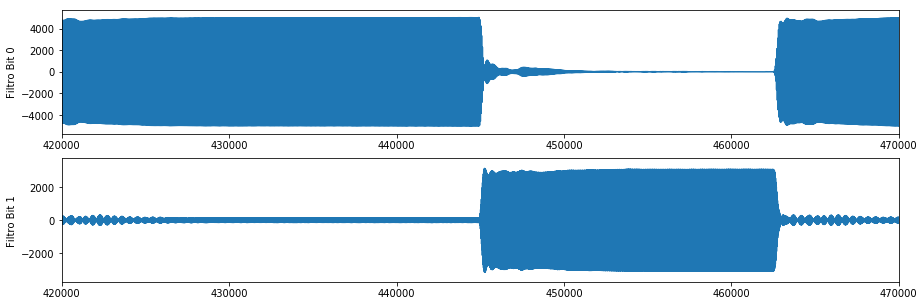

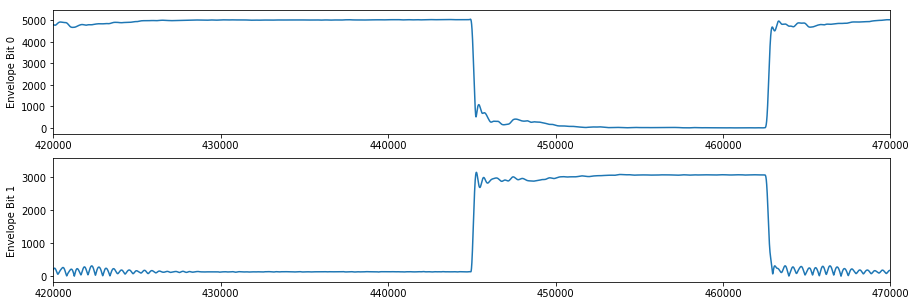

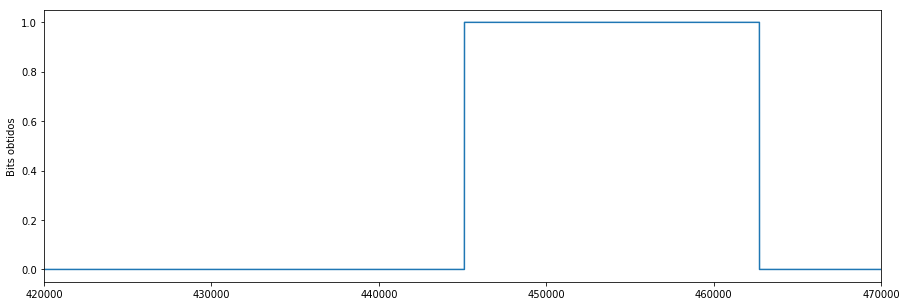

In [15]:
Fs, wave = wavfile.read("../hello_rec.wav")

## Função FSKdemod para apresentação ##
f0 = 1400.0
df = 500.0

low_freq = f0 - df
high_freq = f0 + df
# Criacao dos filtros de Butterworth (passa faixa em high\low_freq +\- 100Hz)
filter_order = 5
dev = 100
sos_low = signal.butter(filter_order, [(
    low_freq - dev), (low_freq + dev)], btype='band', fs=Fs, output='sos')
sos_high = signal.butter(filter_order, [(
    high_freq - dev), (high_freq + dev)], btype='band', fs=Fs, output='sos')

# Filtragem da entrada
low_wave = signal.sosfilt(sos_low, wave)
high_wave = signal.sosfilt(sos_high, wave)

plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(low_wave)
plt.ylabel("Filtro Bit 0")
plt.xlim(420000, 470000)
plt.subplot(212)
plt.plot(high_wave)
plt.ylabel("Filtro Bit 1")
plt.xlim(420000, 470000)

# Deteccao de envelope
low_wave = np.abs(signal.hilbert(low_wave))
high_wave = np.abs(signal.hilbert(high_wave))

plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(low_wave)
plt.ylabel("Envelope Bit 0")
plt.xlim(420000, 470000)
plt.subplot(212)
plt.plot(high_wave)
plt.ylabel("Envelope Bit 1")
plt.xlim(420000, 470000)

# Subtracao dos sinais para comparacao
bitwave = high_wave/max(high_wave) - low_wave/max(low_wave)
bitwave[bitwave > 0.0] = 1.0
bitwave[bitwave <= 0.0] = 0.0

plt.figure(figsize=(15,5))
plt.plot(bitwave)
plt.ylabel("Bits obtidos")
plt.xlim(420000, 470000)

### Subamostragem

Deve seguir a taxa de bits da comunicação, pois leva em conta o _número de amostras por bit_ para fazer uma média.


In [16]:
bits = bitwaveSample(bitwave)
print(len(bits))

329


## Decodificação

Consiste no processo de sincronização e obtenção da mensagem a partir de um vetor de bits.

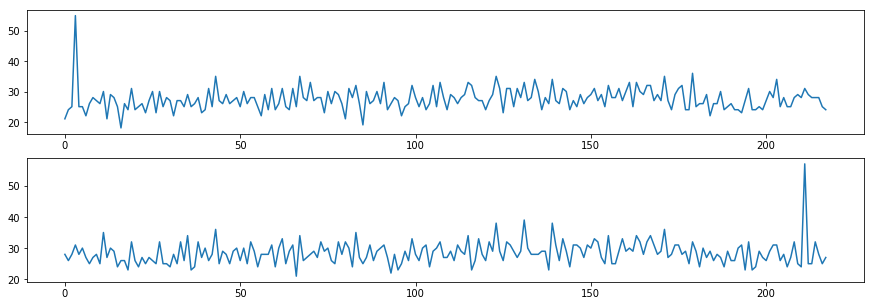

In [17]:
plt.figure(figsize=(15,5))
bits = sincronizeBits(bits)

In [18]:
print("Mensagem gravada: ", bitsToString(bits))

Mensagem gravada:  Hello World!


## Testes e Resultados

Foram feitos alguns testes em ambiente fechado, variando-se a distância e a taxa de bits por segundo. Para uma única mensagem de 400 bits, foi obtida a taxa de erro de bit (_BER_) pela equação:

<p align="center">
    <a href="https://www.codecogs.com/eqnedit.php?latex=BER&space;=&space;\frac{\&hash;\&space;bits\&space;errados}{\&hash;\&space;bits\&space;total}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?BER&space;=&space;\frac{\&hash;\&space;bits\&space;errados}{\&hash;\&space;bits\&space;total}" title="BER = \frac{\#\ bits\ errados}{\#\ bits\ total}" /></a>
</p>

A frequência de centro foi fixada em 1400 Hz e o desvio de frequência em 500 Hz. A taxa de amostragem para a gravação foi de 44100 Hz. Os resultados foram:

<img src="ber_15cm.png" style="float: left; margin-left: 10%" />
<img src="ber_1m.png" style="float: right; margin-right: 10%" />
<img src="ber_2m.png" style="float: center;" />


## Considerações Finais

 - Taxa de erro aumenta com a distância e com o aumento da taxa de bits
 - Principal motivo é diminuição da razão SNR com o aumento da distância
 - Outro motivo provável é a presença de reflexões e reverberação em ambiente fechado
 - Ainda assim, mostrou-se uma comunicação bastante limitada

Realizar em testes futuros:

 - Capturar o sinal em ambiente aberto, com pouco ruído se possível (ou aumentar a SNR)
 - Medir o desempenho da comunicação em câmara anecóica

Desafio e Possibilidade:

 - Implementar um processo que realize conversa em tempo real, sem a necessidade de gravação
 